**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 7 - Sísmica de reflexão: Aquisição, seção sísmica e difração

Nesta prática, vamos fazer a simulação de uma aquisição de sísmica de reflexão. Vamos separar os dados obtidos em CMPs, fazer a análise de velocidade, correção NMO e empilhamento. Por fim, vamos ver qual é o efeito de variações na topografia da camada na seção sísmica final empilhada.

As tarefas abaixo acompanham as questões que vocês devem responder. Usem as simulações abaixo para te ajudar a responder as perguntas.

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [2]:
%matplotlib inline
from __future__ import division
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.html import widgets
from IPython import display
from fatiando import utils
from fatiando.seismic.wavefd import Ricker, ElasticSH
from fatiando.vis import mpl
import fatiando
from multiprocessing import Pool

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
print(fatiando.__version__)

0.3-224-gb6a56f8


## Geometria de aquisição

Rode a célula abaixo para gerar uma figura interativa que simula a geometria de uma aquisição.

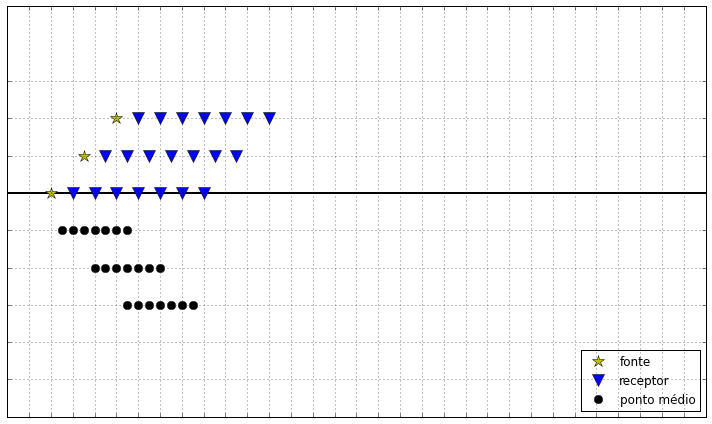

In [10]:
def plot_aquisicao(fontes, receptores, passo, raios, mesma_linha):
    offset = 1
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    fontes = np.arange(0, fontes*passo, passo)
    for i, f in enumerate(fontes):
        if mesma_linha:
            i = 0
        recep = f + np.arange(offset, offset*receptores, offset)
        mid = (f + recep)/2
        tmp = i*np.ones_like(recep)
        if raios:
            for r, m in zip(recep, mid):
                plt.plot([f, m, r], [i + 1, -i, i + 1], '-k')
        plotf, = plt.plot(f, i + 1, '*y', markersize=12)
        plotr, = plt.plot(recep, tmp + 1, 'vb', markersize=12)
        plotm, = plt.plot(mid, -tmp, 'ok', markersize=8) 
    plt.legend((plotf, plotr, plotm), 
               ('fonte', 'receptor', u'ponto médio'),
               numpoints=1, fancybox=False, loc='lower right')
    plt.xlim(-2, 30)
    plt.ylim(-5, 6)
    plt.xticks(range(-2, 30, 1))
    plt.yticks(range(-5, 5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.hlines(1, -2, 30, linewidth=2)
    plt.grid()
    plt.tight_layout()
widgets.interactive(plot_aquisicao, fontes=(1, 5, 1), receptores=(1, 15, 1), passo=(0.5, 3, 0.5),
                    raios=False, mesma_linha=False)

Na figura acima, você pode controlar o número de fontes que serão utilizadas, o número de receptores e o tamanho do passo que é dado com o arranjo entre um tiro e outro. Note que o arranjo anda "para cima" somente para efeito da visualização. Na realidade ele é movido em linha reta ao longo da superfície. Clique na opção "mesma_linha" para ver como seria o arranjo na realidade. Use o botão "raios" para mostrar os raios das reflexões.

## Simulação de uma aquisição

Em seguida, vamos usar a modelagem direta por diferenças finitas para simular uma aquisição.

### Preparação

Abaixo, estabelecemos um modelo de velocidades para nossa simulação. Essa será a nossa "realidade". Para deixar as coisas mais interessantes, vamos fazer um modelo com um degrau.

In [11]:
shape = (150, 500)
spacing = 5
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*1600
velocidade = np.ones(shape)*4000
l1 = 400//spacing
densidade[l1:,:] = 1800
velocidade[l1:,:] = 5000
densidade[l1 - 150//spacing:l1, 1000//spacing:] = 1800
velocidade[l1 - 150//spacing:l1, 1000//spacing:] = 5000

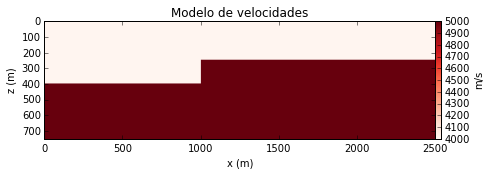

In [18]:
plt.figure(figsize=(10, 2.5))
plt.title('Modelo de velocidades')
plt.imshow(velocidade, extent=extent, cmap='Reds')
plt.colorbar(pad=0).set_label('m/s')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.tight_layout()

Agora, vamos estabelecer a geometria de nossa aquisição.

In [22]:
offset = 40//spacing
passo_fonte = 2*offset
fontes = np.array(range(65, shape[1]//2, passo_fonte), dtype=np.int)
offsets = np.array(range(offset, shape[1] - 150 - fontes[-1], offset), dtype=np.int)
print("Utilizando {} fontes e {} receptores com offset de {} m.".format(len(fontes), len(offsets), offset*spacing))
print('Fontes:  {}'.format(fontes*spacing))
print('Offsets: {}'.format(offsets*spacing))

Utilizando 12 fontes e 13 receptores com offset de 40 m.
Fontes:  [ 325  405  485  565  645  725  805  885  965 1045 1125 1205]
Offsets: [ 40  80 120 160 200 240 280 320 360 400 440 480 520]


E agora podemos rodar as simulações. Precisamos de uma simulação por tiro, então faremos 12 no total.

Rode as duas células abaixo para rodar todas as simulações (isso vai demorar um pouco).

In [23]:
def run_sim(fonte, end=0.3):
    sim = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.004, padding=60, verbose=False)
    sim.add_point_source((0, fonte), Ricker(5, 60, 1/60))
    its = int(end/sim.dt)
    sim.run(its)
    return sim

In [24]:
print('Simulando...')
t = time.time()
pool = Pool()
sims = pool.map(run_sim, fontes)
pool.close()
print('Terminado ({} s).'.format(time.time() - t))

Simulando...
Terminado (40.0921599865 s).


### Extraindo os dados da simulação

Vamos extrair os dados das simulações. De cada simulação/tiro, vamos extrair os sismogramas correspondentes aos receptores daquele tiro.

In [25]:
shots = [sims[i][:, 0, f + offsets] for i, f in enumerate(fontes)]
dt = sims[0].dt
times = np.arange(sims[0].size)*dt

Rode a célula baixo para gerar gráficos dos sismogramas de cada tiro. Cada coluna no gráfico abaixo representa os dados de um receptor.

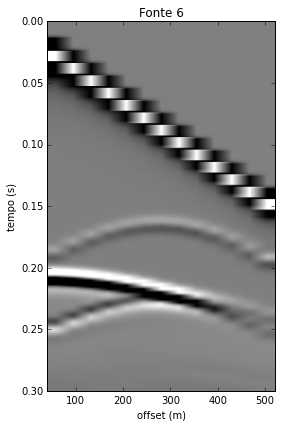

In [26]:
def plot_shots(fonte):
    shot = shots[fonte - 1]
    plt.figure(figsize=(4, 6))
    plt.title("Fonte {}".format(fonte))
    x = offsets*spacing
    mpl.seismic_image(shot, dt=dt, ranges=(x.min(), x.max()), 
                      vmin=-0.00005, vmax=0.00005, aspect='auto')
    plt.xlabel(u'offset (m)')
    plt.ylabel('tempo (s)')
    plt.tight_layout()
widgets.interactive(plot_shots, fonte=(1, len(fontes), 1))

Tente reconhecer os eventos presentes nos dados acima. Há dois eventos que nunca vimos antes. Para entender de onde eles vieram, vamos gerar uma animação de um dos tiros. Note o que acontece quando a frente de onda incide sobre a quina do modelo.

In [30]:
sims[2].animate(10, embed=True, dpi=70, fps=7, cutoff=0.00005, cmap='Greys')

Rode a célula abaixo para poder explorar cada etapa da animação uma a uma.

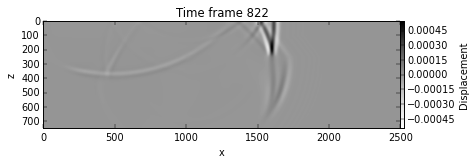

<function fatiando.seismic.wavefd.plot>

In [32]:
sims[2].explore(every=10, cmap='Greys')

### Organização dos dados em CMPs

Agora que temos nossos *shot gathers* (conjuntos de dados referentes a cada tiro), podemos organizar os dados em *CMP gathers* (conjuntos que compartilham um ponto médio).

In [34]:
midpoints = np.empty((len(fontes), len(offsets)), dtype=np.int)
for i, f in enumerate(fontes):
    midpoints[i, :] = (f + (f + offsets))/2
cmps = []
for mid in np.unique(midpoints):
    src, rec = (midpoints == mid).nonzero()
    assert len(src) == len(rec), "Epa, deu algo errado."
    if len(src) > 3:
        CMP = np.transpose([shots[i][:, j] for i, j in zip(src, rec)])
        cmps.append([mid*spacing, offsets[rec][::-1], CMP[:, ::-1]])
coordenadas = np.array([x for x, _, _ in cmps])

Rode a célula abaixo para gerar gráficos dos nossos CMPs. Note que também é mostrado o *fold* (número de traços no CMP) e a coordenada x do ponto médio a que se refere o CMP.

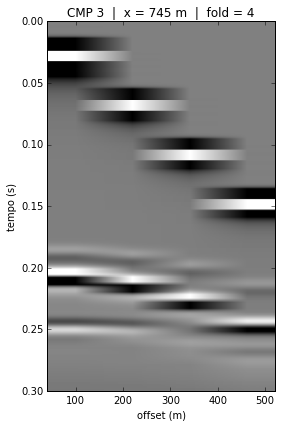

In [36]:
def plot_cmps(CMP):
    x, off, dados = cmps[CMP - 1]
    plt.figure(figsize=(4, 6))
    plt.title("CMP {}  |  x = {} m  |  fold = {}".format(CMP, x, len(off)))
    d = off*spacing
    gain = 0.00005
    mpl.seismic_image(dados, dt=dt, ranges=(d.min(), d.max()), 
                      vmin=-gain, vmax=gain, aspect='auto')
    plt.xlabel(u'offset (m)')
    plt.ylabel('tempo (s)')
    plt.tight_layout()
widgets.interactive(plot_cmps, CMP=(1, len(cmps), 1))

### Análise de velocidades

Rode a célula abaixo para fazer a análise de velocidades dos CMPs. Você poderá escolher qual CMP que utilizar para fazer a análise. **Tome cuidado com as difrações**, elas podem atrapalhar a sua análise.

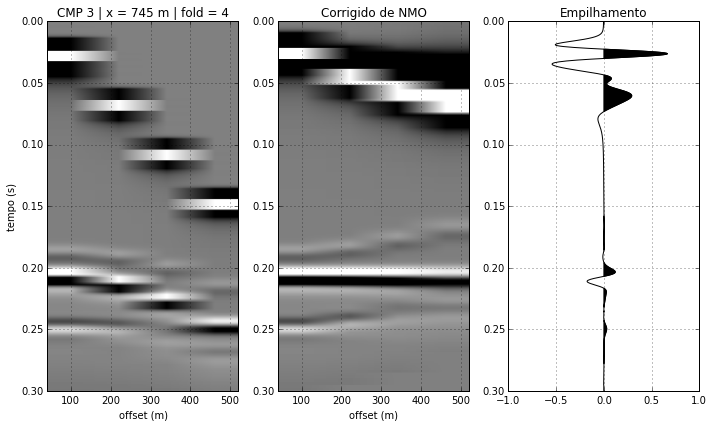

In [37]:
def nmo_correction(CMP, times, offsets, v):
    nmo = np.zeros_like(CMP)
    for i, t0 in enumerate(times):
        for j, o in enumerate(offsets):
            t = np.sqrt(t0**2 + o**2/v[i]**2)
            k = t//dt
            if k < times.size - 1:
                # Linear interpolation of the amplitude
                y0, y1 = CMP[k, j], CMP[k + 1, j]
                x0, x1 = times[k], times[k + 1]
                nmo[i, j] = y0 + (y1 - y0)*(t - x0)/(x1 - x0)
    return nmo

def nmo_analise(CMP, velocidade):
    v = velocidade*np.ones_like(times)
    x, off, dados = cmps[CMP - 1]
    nmo = nmo_correction(dados, times, off*spacing, v)
    gain = 0.00005
    plt.figure(figsize=(10, 6))
    plt.subplot(131)
    plt.title("CMP {} | x = {} m | fold = {}".format(CMP, x, len(off)))
    d = off*spacing
    ranges = (d.min(), d.max())
    mpl.seismic_image(dados, dt=dt, ranges=ranges, 
                      vmin=-gain, vmax=gain, aspect='auto')
    plt.grid()
    plt.xlabel(u'offset (m)')
    plt.ylabel('tempo (s)')
    plt.subplot(132)
    plt.title('Corrigido de NMO')
    mpl.seismic_image(nmo, dt=dt, ranges=ranges, 
                      vmin=-gain, vmax=gain, aspect='auto')
    plt.grid()
    plt.xlabel(u'offset (m)')
    plt.subplot(133)
    plt.title('Empilhamento')
    stack = np.atleast_2d(nmo.sum(1)).T
    mpl.seismic_wiggle(stack, dt=dt, scale=500)
    plt.xlim(-1, 1)
    plt.grid()
    plt.tight_layout()
    return velocidade
analise_velocidade = widgets.interactive(nmo_analise, CMP=(1, len(cmps), 1), velocidade=(1000, 5000, 100))
analise_velocidade

### Empilhamento

A seguir, vamos utilizar a **velocidade determinada acima** para fazer a correção NMO em todos os CMPs. Feita a correção, vamos empilhar todos os CMPs para produzir nossa **seção de incidência normal**.

In [38]:
print('Velocidade utilizada na correção: {} m/s'.format(analise_velocidade.result))

Velocidade utilizada na correção: 3900 m/s


In [43]:
empilhado = np.empty((len(times), len(cmps)))
v = analise_velocidade.result*np.ones_like(times)
for i, dados in enumerate(cmps):
    x, off, CMP = dados
    nmo = nmo_correction(CMP, times, off*spacing, v)
    # Vamos cortar a parte referente a onda direta
    nmo[times < 0.1, :] = 0
    empilhado[:, i] = nmo.sum(1)

Rode a célula abaixo para plotar a seção empilhada.

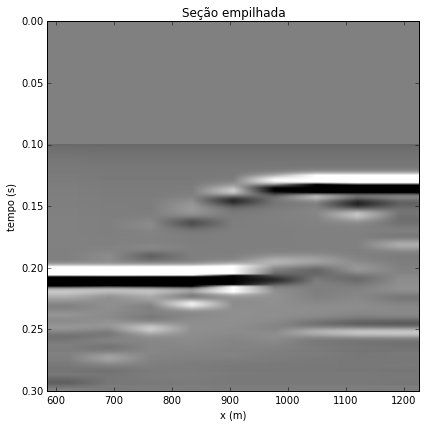

In [44]:
plt.figure(figsize=(6, 6))
plt.title(u"Seção empilhada")
x = coordenadas
gain = 0.0001
mpl.seismic_image(empilhado, dt=dt, ranges=(x.min(), x.max()), 
                  vmin=-gain, vmax=gain, aspect='auto')
plt.xlabel(u'x (m)')
plt.ylabel('tempo (s)')
plt.tight_layout()

Note como foi o imageamento do nosso degrau. O que você vê nas quinas de cima e de baixo? O que é o evento reto entre 1100m e 1200m que chega por volta de 0.25s?